In [12]:
!pip install mysql-connector-python


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','oreder_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='123456',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/OM/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

# List all unique cities where customers are located.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "123456",
                            database = "ecommerce")

cur = db.cursor()

query = """select distinct(customer_city) from customers """
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where order_purchase_timestamp like '2017%'"""
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category. 


In [4]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ select (sum(case when payment_installments >= 1 
then 1 else 0 end))/count(*)*100 from payments  """

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is ",data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

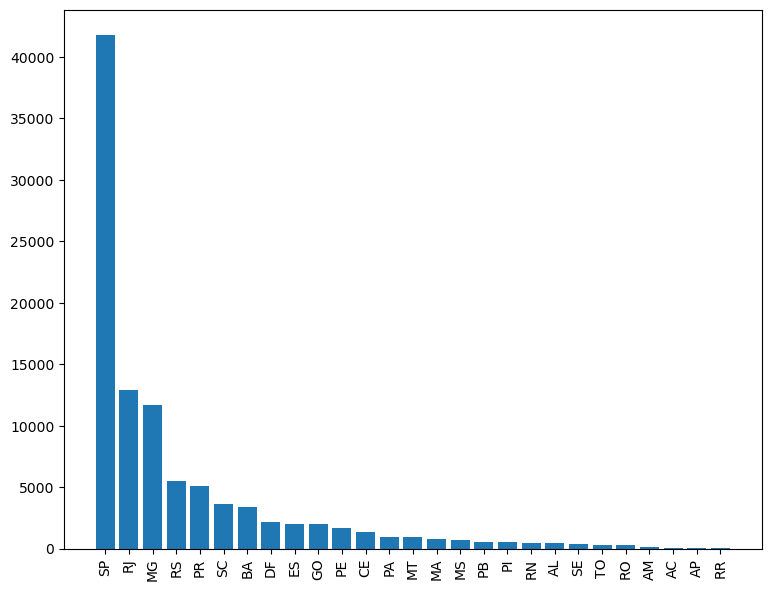

In [11]:
query = """ select customer_state ,count(customer_id) from customers
group by customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (9,7))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018.

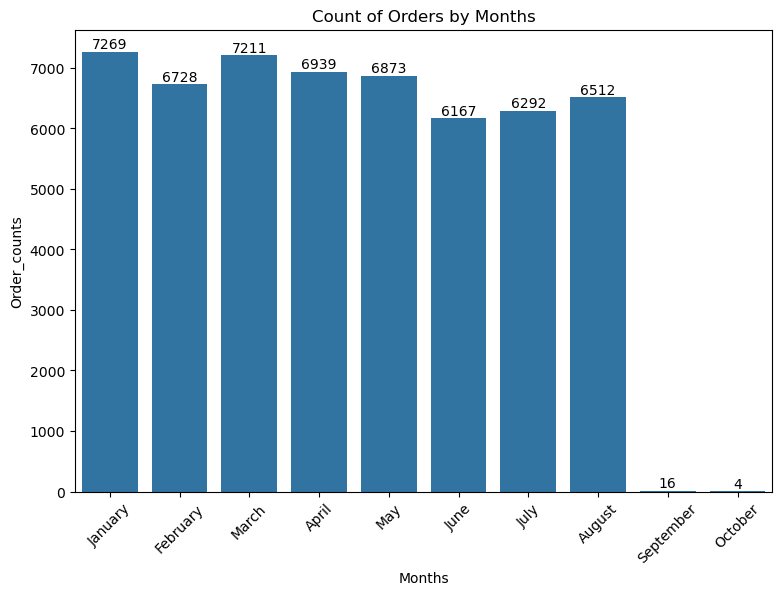

In [12]:
query = """select monthname(order_purchase_timestamp) months,
count(order_id) order_counts from orders
where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","Order_counts"])
o = ["January", "February","March","April","May","June","July","August","September",
     "October"]
plt.figure(figsize=(9,6))
ax = sns.barplot(x = df["Months"], y= df["Order_counts"], data = df, order = o)
plt.title("Count of Orders by Months")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])

plt.show()

# Find the average number of products per order, grouped by customer city.

In [17]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city", "Avg_products"])
df.head(10)

,customer_city,Avg_products
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.


In [21]:
query = """ select products.product_category category ,
 round((sum(payments.payment_value) / (select sum(payments.payment_value) from payments))* 100,2) sales
from products
join order_items on order_items.product_id = products.product_id
join payments on payments.order_id = order_items.order_id
Group by category
order by sales desc;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "%_total_revenue"])
df.head(10)

,category,%_total_revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

Correlation between product price and the number of times a product has been purchased is :                product_count  avg_price
product_count       1.000000  -0.106316
avg_price          -0.106316   1.000000


<Axes: >

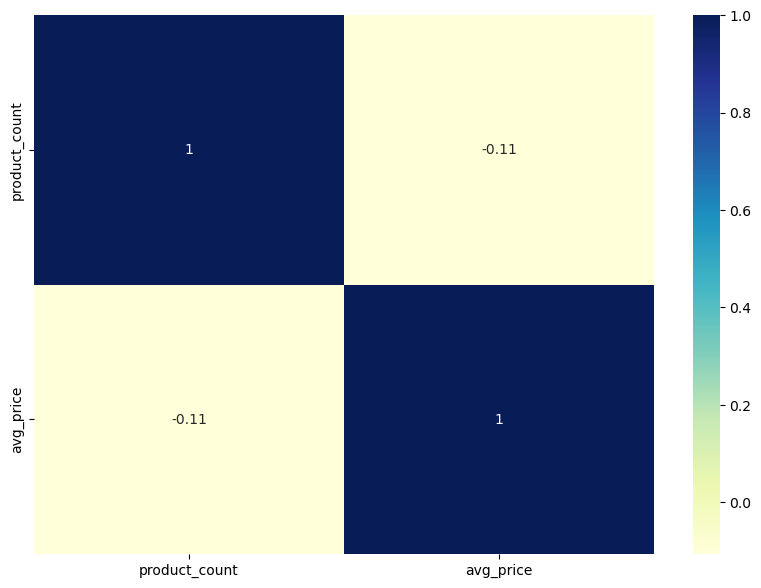

In [9]:
query = """select products.product_category as category, count(order_items.order_id) , avg(order_items.price)
from products join order_items
on products.product_id = order_items.product_id
group by category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["category","product_count", "avg_price"])
corr = df.corr(numeric_only=True)
print("Correlation between product price and the number of times a product has been purchased is :",corr)
plt.figure(figsize= (10,7))
sns.heatmap(corr, annot=True, cmap='YlGnBu')

# Calculate the total revenue generated by each seller, and rank them by revenue.

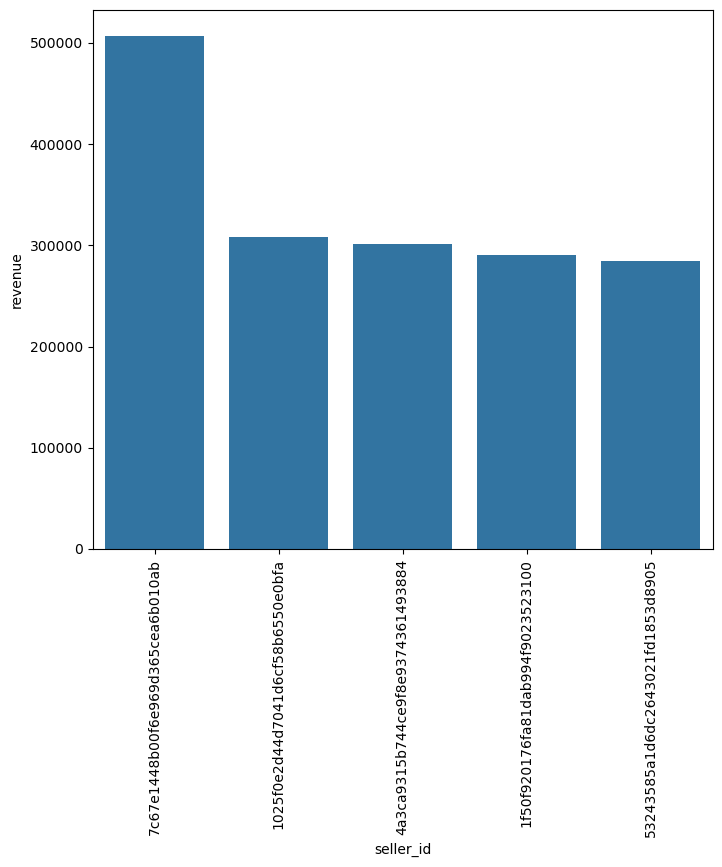

In [7]:
query = """ select *, dense_rank() over(order by revenue desc) as RN from
(select order_items.seller_id, round(sum(payments.payment_value),2) revenue
from order_items
join payments on payments.order_id = order_items.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue","rank"])
df = df.head()
plt.figure(figsize=(8,7))
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [58]:
query = """ select customer_id , order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id","timestamp","payment","Moving_avg"])
df.tail(10)

,customer_id,timestamp,payment,Moving_avg
103876,fffb97495f78be80e2759335275df2aa,2018-01-16 14:51:35,61.01,61.009998
103877,fffc22669ca576ae3f654ea64c8f36be,2017-06-30 11:21:11,101.56,101.559998
103878,fffcb937e9dd47a13f05ecb8290f4d3e,2018-03-17 00:55:27,91.91,91.910004
103879,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,0.640000
103880,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,5.065000
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
103885,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

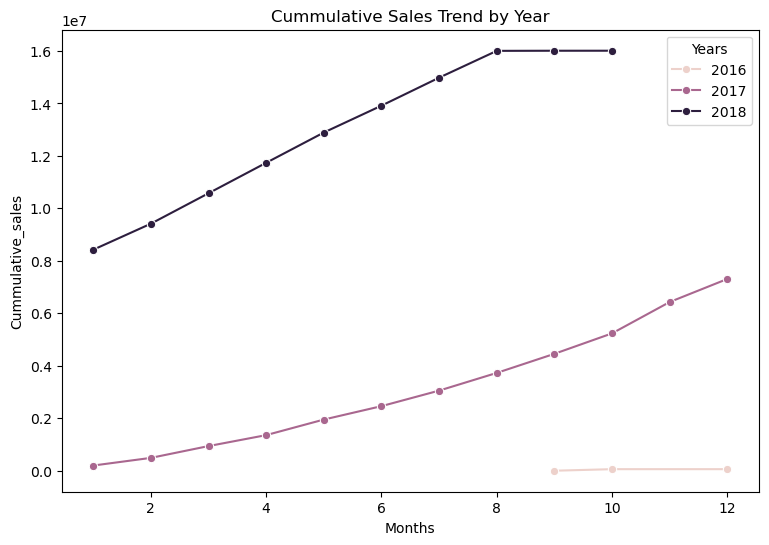

In [13]:
query = """ select years, months, payment, round(sum(payment)
over(order by years, months),2) cummulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from payments
join orders on payments.order_id = orders.order_id
group by years, months
order by years, months) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Months","Payment","Cummulative_sales"])
plt.figure(figsize=(9,6))
sns.lineplot(x="Months", y="Cummulative_sales", hue="Years", data=df, marker="o")
plt.title("Cummulative Sales Trend by Year")
plt.show()